In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# Code example
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [2]:
import h5py
f = h5py.File('s000_f00012_ts1524050665_Phys.h5', 'r')

In [3]:
data1 = f['PhysPulse']
data1.shape

(49258813,)

In [4]:
%%time
x = []
for i in np.arange(1000000):
    y = list(data1[i])
    row = ( y[2],  y[5], y[6][0], y[6][1], y[7], y[8], y[9] )
    x.append(row)
column = [  'E','dt', 'PE1', 'PE2', 'z', 'PSD', 'PID' ]
dataset = pd.DataFrame(x, columns=column)
dataset.head()

CPU times: user 4min 29s, sys: 1.27 s, total: 4min 31s
Wall time: 4min 31s


,E,dt,PE1,PE2,z,PSD,PID
0,2.275780,-0.655549,594.300781,625.927734,24.461338,0.146490,1
1,0.123983,0.636964,38.646969,42.485348,-15.253388,0.256155,4
2,0.048792,5.149928,12.320891,19.019636,-240.913544,0.096845,1
3,0.840343,-5.507163,160.623596,336.638092,325.131561,0.109661,1
4,0.055428,-8.687485,16.618265,28.545994,474.909546,0.000000,1


In [5]:
dataset['PID'].unique()

array([  1,   4, 256, 512, 128,  32,   6, 258])

In [6]:
dataset.drop( dataset[ dataset.PID == 6 ].index, inplace=True )
dataset.drop( dataset[ dataset.PID == 32 ].index, inplace=True )
dataset.drop( dataset[ dataset.PID == 128 ].index, inplace=True )
dataset.drop( dataset[ dataset.PID == 258 ].index, inplace=True )
output = dataset['PID'].unique()
output

array([  1,   4, 256, 512])

In [7]:
# 0:'electron/gamma/muon ionization'
# 1:"nucleus recoil"
# 2:'scintillator-in-housing "ingress" high-PSD event' 
# 3:'big signal (muon likely) hit'

In [8]:
OriginalDataset = dataset['PID'].replace({ 1:'electron/gamma/muon ionization', 4:"nucleus recoil", 256:'scintillator-in-housing "ingress" high-PSD event',  512:'big signal (muon likely) hit' })
dataset['PID'].replace({ 1:0, 4:1, 256:2, 512:3 } , inplace=True)

In [9]:
dataset['PID'].value_counts()

0    769448
3    190875
1     28453
2      4519
Name: PID, dtype: int64

In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [11]:
train_labels = train_dataset.pop('PID')
test_labels = test_dataset.pop('PID')

In [12]:
train_dataset.keys()

Index(['E', 'dt', 'PE1', 'PE2', 'z', 'PSD'], dtype='object')

In [13]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_dataset.keys()),)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(output))
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.fit(train_dataset, train_labels, epochs=10)

Train on 794636 samples
Epoch 1/10
794636/794636 [==============================] - 56s 71us/sample - loss: 1.0987 - accuracy: 0.9404
Epoch 2/10
794636/794636 [==============================] - 59s 74us/sample - loss: 0.1482 - accuracy: 0.9566
Epoch 3/10
794636/794636 [==============================] - 58s 73us/sample - loss: 0.1335 - accuracy: 0.9590
Epoch 4/10
794636/794636 [==============================] - 56s 70us/sample - loss: 0.1238 - accuracy: 0.9615
Epoch 5/10
794636/794636 [==============================] - 46s 58us/sample - loss: 0.1198 - accuracy: 0.9642
Epoch 6/10
794636/794636 [==============================] - 42s 53us/sample - loss: 0.1099 - accuracy: 0.9659
Epoch 7/10
794636/794636 [==============================] - 40s 51us/sample - loss: 0.1175 - accuracy: 0.9652
Epoch 8/10
794636/794636 [==============================] - 40s 51us/sample - loss: 0.1087 - accuracy: 0.9669
Epoch 9/10
794636/794636 [==============================] - 47s 59us/sample - loss: 0.0971 - acc

In [15]:
test_loss, test_acc = model.evaluate(test_dataset,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

198659/198659 - 6s - loss: 0.0871 - accuracy: 0.9687

Test accuracy: 0.96868


In [16]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [17]:
predictions = probability_model.predict(test_dataset)

In [18]:
PreLabel = [ np.argmax(x) for x in predictions ]
PreLabel
PreLabel = pd.Series(PreLabel,name='Predict')
PreLabel.shape
test_dataset.shape


(198659, 6)

In [19]:
testD = test_dataset.copy()
testD.reset_index(drop=True, inplace=True)
testD_labels = test_labels.copy()
testD_labels.reset_index(drop=True, inplace=True)
testD_labels

0         1
1         0
2         3
3         0
4         0
         ..
198654    0
198655    0
198656    3
198657    0
198658    0
Name: PID, Length: 198659, dtype: int64

In [20]:
result = pd.concat([testD, PreLabel,testD_labels], axis=1)
result

,E,dt,PE1,PE2,z,PSD,Predict,PID
0,0.123983,0.636964,38.646969,42.485348,-15.253388,0.256155,1,1
1,0.055428,-8.687485,16.618265,28.545994,474.909546,0.000000,0,0
2,32.202950,-3.190318,9501.229492,12595.092773,127.709473,0.145308,3,3
3,0.084843,3.542499,17.743114,32.411461,-124.181038,0.092327,0,0
4,1.232020,-9.197167,112.410690,734.446289,564.590515,0.152809,0,0
...,...,...,...,...,...,...,...,...
198654,0.704876,6.357671,346.806427,146.288773,-384.555328,0.143204,0,0
198655,0.708429,6.884195,300.207245,137.095413,-374.400482,0.140275,0,0
198656,43.182083,-4.775603,10367.714844,14909.932617,165.492401,0.190751,3,3
198657,0.998247,-8.696716,234.429398,490.739471,378.468811,0.169858,0,0


In [21]:
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# # plt.rcParams['axes.spines.right'] = True
# rc = {"axes.spines.bottom" : False,
#       "axes.spines.top"    : False,
#       "figur.titlesize"    : BIGGER_SIZE ,
#       "axes.spines.right"  : False}
# plt.style.use(("seaborn-colorblind", rc))
# plt.style.use('py_style')

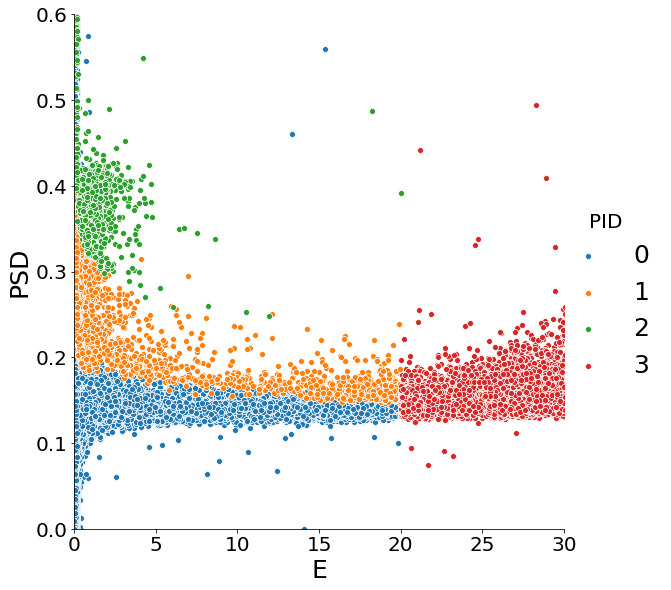

In [22]:
# sns.despine(top=False,right=False)
ax = sns.pairplot(x_vars=["E"], y_vars=["PSD"], data=result, hue="PID", height=8)
ax.set(xlim=(0,30))
ax.set(ylim=(0,0.6))
plt.savefig("test.png")

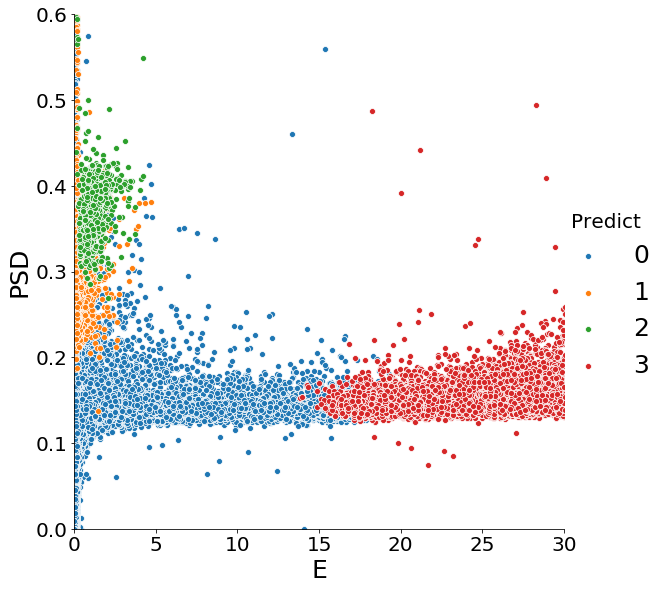

In [23]:
ax = sns.pairplot(x_vars=["E"], y_vars=["PSD"], data=result, hue="Predict", height=8)
ax.set(xlim=(0,30))
ax.set(ylim=(0,0.6))
# plt.savefig("prediction.pdf")
plt.savefig("prediction.png")

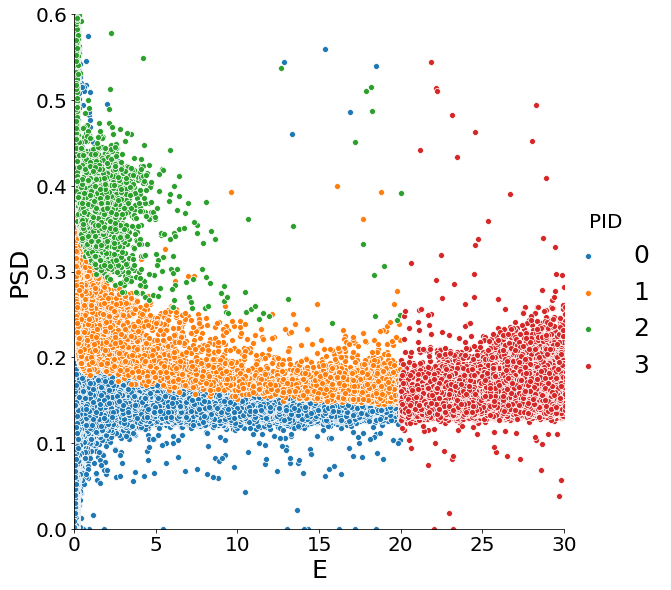

In [24]:
ax = sns.pairplot(x_vars=["E"], y_vars=["PSD"], data=dataset, hue='PID', height=8)
ax.set(xlim=(0,30))
ax.set(ylim=(0,0.6))
plt.savefig("train.png")

In [25]:
## result analysis 
# print(result.shape[0])
true0 = result[result['PID']==0]
true1 = result[result['PID']==1]
true2 = result[result['PID']==2]
true3 = result[result['PID']==3]
result['PID'].value_counts()

0    154029
3     37938
1      5815
2       877
Name: PID, dtype: int64

In [26]:
print('PID = [ {} ] accuracy = {} / {}  =  {}  '.format( 0  , true0['Predict'].value_counts()[0] , true0.shape[0] , true0['Predict'].value_counts()[0] / true0.shape[0]) )     
print('PID = [ {} ] accuracy = {} / {}  =  {}  '.format( 1  , true1['Predict'].value_counts()[1] , true1.shape[0] , true1['Predict'].value_counts()[1] / true1.shape[0]) )  
print('PID = [ {} ] accuracy = {} / {}  =  {}  '.format( 2  , true2['Predict'].value_counts()[2] , true2.shape[0] , true2['Predict'].value_counts()[2] / true2.shape[0]) )     
print('PID = [ {} ] accuracy = {} / {}  =  {}  '.format( 3  , true3['Predict'].value_counts()[3] , true3.shape[0] , true3['Predict'].value_counts()[3] / true3.shape[0]) )     

PID = [ 0 ] accuracy = 151065 / 154029  =  0.9807568704594589  
PID = [ 1 ] accuracy = 2826 / 5815  =  0.48598452278589854  
PID = [ 2 ] accuracy = 610 / 877  =  0.6955530216647663  
PID = [ 3 ] accuracy = 37936 / 37938  =  0.9999472824081396  
